In [4]:
# Setup: Add project root to path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✅ Project root: {project_root}")

✅ Project root: /Users/Sakarias/QuantTrading


In [5]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.multi_asset_loader import load_assets
from signals.momentum import MomentumSignalV2

print("✅ Imports successful")

✅ Imports successful


---

## Step 1: Load Price Data

**Source Code:** `core/multi_asset_loader.py` → `load_assets()`

We'll load 2 years of ES (S&P 500 E-mini) futures data.

In [6]:
# Load ES data for 2023-2024 (short period for clarity)
prices = load_assets(
    tickers=['ES'],
    start_date='2023-01-01',
    end_date='2024-12-31'
)

df = prices['ES']

print(f"\n📊 Data Shape: {df.shape}")
print(f"📅 Date Range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\n🔍 First 3 rows:")
print(df[['Close', 'Volume']].head(3))
print(f"\n🔍 Last 3 rows:")
print(df[['Close', 'Volume']].tail(3))


Loading 1 assets: ['ES']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2023-01-01 to 2024-12-31

Total unique dates: 503

ALIGNMENT SUMMARY
ES: 503/503 valid dates (100.0%)

📊 Data Shape: (503, 6)
📅 Date Range: 2023-01-03 to 2024-12-31

🔍 First 3 rows:
             Close   Volume
Date                       
2023-01-03  3846.0  1782473
2023-01-04  3874.5  1912155
2023-01-05  3829.0  1679973

🔍 Last 3 rows:
              Close   Volume
Date                        
2024-12-27  6027.00  1641100
2024-12-30  5958.75  1575134
2024-12-31  5935.75  1382187
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2023-01-01 to 2024-12-31

Total unique dates: 503

ALIGNMENT SUMMARY
ES: 503/503 valid date

---

## Step 2: Generate Trading Signals

**Source Code:** `signals/momentum.py` → `MomentumSignalV2`

The signal logic:
- Calculate 120-day momentum (rate of change)
- Check if price > 200-day SMA (trend filter)
- Signal = 1 if both conditions true, else 0

In [7]:
# Generate signals
signal_gen = MomentumSignalV2(lookback=120, sma_filter=200)
df_with_signal = signal_gen.generate(df)


print("\n🎯 Signal Statistics:")
print(f"Total days: {len(df_with_signal)}")
print(f"Long days: {(df_with_signal['Position'] == 1).sum()}")
print(f"Flat days: {(df_with_signal['Position'] == 0).sum()}")
print(f"\n📋 Sample signals:")
print(df_with_signal[['Close', 'Position']].tail(10))


🎯 Signal Statistics:
Total days: 503
Long days: 283
Flat days: 220

📋 Sample signals:
                  Close  Position
Date                             
2024-12-17  6053.750000       1.0
2024-12-18  5872.250000       1.0
2024-12-19  5868.750000       1.0
2024-12-20  5840.259766       1.0
2024-12-23  6036.000000       1.0
2024-12-24  6098.000000       1.0
2024-12-26  6095.250000       1.0
2024-12-27  6027.000000       1.0
2024-12-30  5958.750000       1.0
2024-12-31  5935.750000       1.0


---

## Step 3: Initialize Portfolio State

**Key Variables:**
- `cash`: Money available (starts at initial capital)
- `shares`: Number of contracts held (starts at 0)
- `portfolio_value`: Total wealth (cash + position value)

**What Happens:**
When signal = 1 (long), we buy shares worth 100% of capital.

In [8]:
# Portfolio initialization
INITIAL_CAPITAL = 100000
TRANSACTION_COST_BPS = 3.0  # 0.03% per trade

cash = INITIAL_CAPITAL
shares = 0
trades = []
equity_curve = []

print("\n💰 Initial State:")
print(f"  Cash: ${cash:,.2f}")
print(f"  Shares: {shares}")
print(f"  Portfolio Value: ${cash:,.2f}")


💰 Initial State:
  Cash: $100,000.00
  Shares: 0
  Portfolio Value: $100,000.00


---

## Step 4: First Trade - Enter Position

Let's find the first day where signal = 1 and execute our first trade.

**Transaction Cost Calculation:**
```
cost = trade_value × (cost_bps / 10000)
cost = $100,000 × (3 / 10000) = $30
```

In [9]:
# Find first signal = 1
first_signal_date = df_with_signal[df_with_signal['Position'] == 1].index[0]
first_signal_price = df_with_signal.loc[first_signal_date, 'Close']

print(f"\n🚦 First LONG Signal:")
print(f"  Date: {first_signal_date.date()}")
print(f"  Price: ${first_signal_price:,.2f}")

# Calculate trade
target_value = cash  # Invest 100%
shares_to_buy = target_value / first_signal_price
trade_value = shares_to_buy * first_signal_price
transaction_cost = abs(trade_value) * (TRANSACTION_COST_BPS / 10000)

print(f"\n💵 Trade Calculation:")
print(f"  Available cash: ${cash:,.2f}")
print(f"  Shares to buy: {shares_to_buy:.4f}")
print(f"  Trade value: ${trade_value:,.2f}")
print(f"  Transaction cost: ${transaction_cost:,.2f}")
print(f"  Total cost: ${trade_value + transaction_cost:,.2f}")

# Execute trade
shares = shares_to_buy
cash -= (trade_value + transaction_cost)

print(f"\n✅ After Trade:")
print(f"  Cash: ${cash:,.2f}")
print(f"  Shares: {shares:.4f}")
print(f"  Position Value: ${shares * first_signal_price:,.2f}")
print(f"  Portfolio Value: ${cash + shares * first_signal_price:,.2f}")

# Record trade
trades.append({
    'Date': first_signal_date,
    'Type': 'ENTRY',
    'Price': first_signal_price,
    'Shares': shares_to_buy,
    'Value': trade_value,
    'Cost': transaction_cost
})


🚦 First LONG Signal:
  Date: 2023-11-16
  Price: $4,523.25

💵 Trade Calculation:
  Available cash: $100,000.00
  Shares to buy: 22.1080
  Trade value: $100,000.00
  Transaction cost: $30.00
  Total cost: $100,030.00

✅ After Trade:
  Cash: $-30.00
  Shares: 22.1080
  Position Value: $100,000.00
  Portfolio Value: $99,970.00


---

## Step 5: Track Position Value Over Time

Now let's see what happens to our portfolio value as the price moves.

**Key Formula:**
```
Portfolio Value = Cash + (Shares × Current Price)
```

In [10]:
# Show portfolio value for next 10 days
print("\n📈 Portfolio Value Over Next 10 Days:\n")
print(f"{'Date':<12} {'Price':>10} {'Position Value':>15} {'Cash':>12} {'Total Value':>12} {'P&L':>10}")
print("-" * 80)

start_idx = df_with_signal.index.get_loc(first_signal_date)
for i in range(10):
    date = df_with_signal.index[start_idx + i]
    price = df_with_signal.loc[date, 'Close']
    position_value = shares * price
    portfolio_value = cash + position_value
    pnl = portfolio_value - INITIAL_CAPITAL
    
    print(f"{date.date()} {price:>10,.2f} {position_value:>15,.2f} {cash:>12,.2f} {portfolio_value:>12,.2f} {pnl:>10,.2f}")


📈 Portfolio Value Over Next 10 Days:

Date              Price  Position Value         Cash  Total Value        P&L
--------------------------------------------------------------------------------
2023-11-16   4,523.25      100,000.00       -30.00    99,970.00     -30.00
2023-11-17   4,527.50      100,093.96       -30.00   100,063.96      63.96
2023-11-20   4,562.25      100,862.21       -30.00   100,832.21     832.21
2023-11-21   4,551.25      100,619.02       -30.00   100,589.02     589.02
2023-11-22   4,567.25      100,972.75       -30.00   100,942.75     942.75
2023-11-23   4,569.50      101,022.49       -30.00   100,992.49     992.49
2023-11-24   4,568.25      100,994.86       -30.00   100,964.86     964.86
2023-11-27   4,561.00      100,834.58       -30.00   100,804.58     804.58
2023-11-28   4,563.00      100,878.79       -30.00   100,848.79     848.79
2023-11-29   4,559.25      100,795.89       -30.00   100,765.89     765.89


---

## Step 6: Handle Signal Change (Exit)

What happens when signal changes from 1 → 0?

**We must:**
1. Sell all shares
2. Pay transaction costs
3. Update cash and shares

In [ ]:
# Find first signal change from 1 to 0
signals = df_with_signal['Position'].values
exit_date = None
exit_price = None

for i in range(start_idx + 1, len(signals)):
    if signals[i-1] == 1 and signals[i] == 0:
        exit_date = df_with_signal.index[i]
        exit_price = df_with_signal.loc[exit_date, 'Close']
        break


if exit_date is None:
    print("\n⚠️ No EXIT signal found in the data range!")
    print("The strategy remained LONG for the entire period after entry.")
else:
    print(f"\n🛑 First EXIT Signal:")
    print(f"  Date: {exit_date.date()}")
    print(f"  Price: ${exit_price:,.2f}")

    print(f"\n📊 Before Exit:")
    print(f"  Cash: ${cash:,.2f}")
    print(f"  Shares: {shares:.4f}")
    print(f"  Position Value: ${shares * exit_price:,.2f}")

    # Calculate exit
    shares_to_sell = shares
    trade_value = shares_to_sell * exit_price
    transaction_cost = abs(trade_value) * (TRANSACTION_COST_BPS / 10000)

    print(f"\n💸 Exit Trade:")
    print(f"  Shares to sell: {shares_to_sell:.4f}")
    print(f"  Sale proceeds: ${trade_value:,.2f}")
    print(f"  Transaction cost: ${transaction_cost:,.2f}")
    print(f"  Net proceeds: ${trade_value - transaction_cost:,.2f}")

    # Execute exit
    cash += (trade_value - transaction_cost)
    shares = 0

    print(f"\n✅ After Exit:")
    print(f"  Cash: ${cash:,.2f}")
    print(f"  Shares: {shares:.4f}")
    print(f"  Portfolio Value: ${cash:,.2f}")
    print(f"  Total P&L: ${cash - INITIAL_CAPITAL:,.2f} ({(cash/INITIAL_CAPITAL - 1)*100:.2f}%)")

    # Record trade
    trades.append({
        'Date': exit_date,
        'Type': 'EXIT',
        'Price': exit_price,
        'Shares': -shares_to_sell,
        'Value': trade_value,
        'Cost': transaction_cost
    })


⚠️ No EXIT signal found in the data range!
The strategy remained LONG for the entire period after entry.

⚠️ No EXIT signal found in the data range!
The strategy remained LONG for the entire period after entry.


---

## Step 7: Full Backtest Loop

Now let's do this for the ENTIRE 2-year period.

**Logic:**
```python
for each day:
    if signal changed:
        execute trade (with costs)
    update position value
    record equity curve
```

In [13]:
# Reset for full backtest
cash = INITIAL_CAPITAL
shares = 0
trades = []
equity_curve = []
prev_signal = 0

print("\n🔄 Running Full Backtest...\n")

for date, row in df_with_signal.iterrows():
    price = row['Close']
    signal = row['Position']
    
    # Check for signal change
    if signal != prev_signal:
        # Calculate target position
        if signal == 1:  # Enter long
            target_shares = cash / price
        else:  # Exit (go flat)
            target_shares = 0
        
        # Execute trade
        shares_to_trade = target_shares - shares
        if abs(shares_to_trade) > 0.001:  # Avoid tiny trades
            trade_value = abs(shares_to_trade * price)
            transaction_cost = trade_value * (TRANSACTION_COST_BPS / 10000)
            
            if shares_to_trade > 0:  # Buying
                cash -= (trade_value + transaction_cost)
            else:  # Selling
                cash += (trade_value - transaction_cost)
            
            shares = target_shares
            
            trades.append({
                'Date': date,
                'Type': 'ENTRY' if signal == 1 else 'EXIT',
                'Price': price,
                'Shares': shares_to_trade,
                'Value': trade_value,
                'Cost': transaction_cost
            })
        
        prev_signal = signal
    
    # Record daily portfolio value
    position_value = shares * price
    portfolio_value = cash + position_value
    
    equity_curve.append({
        'Date': date,
        'Close': price,
        'Cash': cash,
        'Shares': shares,
        'PositionValue': position_value,
        'PortfolioValue': portfolio_value
    })

# Convert to DataFrames
trades_df = pd.DataFrame(trades)
equity_df = pd.DataFrame(equity_curve)

print(f"✅ Backtest Complete!")
print(f"\n📊 Summary:")
print(f"  Total Trades: {len(trades_df)}")
print(f"  Final Cash: ${cash:,.2f}")
print(f"  Final Shares: {shares:.4f}")
print(f"  Final Value: ${equity_df['PortfolioValue'].iloc[-1]:,.2f}")
print(f"  Total Return: {(equity_df['PortfolioValue'].iloc[-1] / INITIAL_CAPITAL - 1) * 100:.2f}%")


🔄 Running Full Backtest...

✅ Backtest Complete!

📊 Summary:
  Total Trades: 1
  Final Cash: $-30.00
  Final Shares: 22.1080
  Final Value: $131,197.55
  Total Return: 31.20%


---

## Step 8: Analyze Trades

In [14]:
print("\n📋 All Trades:")
print(trades_df.to_string())

print(f"\n💰 Transaction Costs:")
print(f"  Total costs: ${trades_df['Cost'].sum():,.2f}")
print(f"  Average per trade: ${trades_df['Cost'].mean():,.2f}")
print(f"  % of final value: {trades_df['Cost'].sum() / equity_df['PortfolioValue'].iloc[-1] * 100:.3f}%")


📋 All Trades:
        Date   Type    Price     Shares     Value  Cost
0 2023-11-16  ENTRY  4523.25  22.107998  100000.0  30.0

💰 Transaction Costs:
  Total costs: $30.00
  Average per trade: $30.00
  % of final value: 0.023%


---

## Step 9: Plot Equity Curve

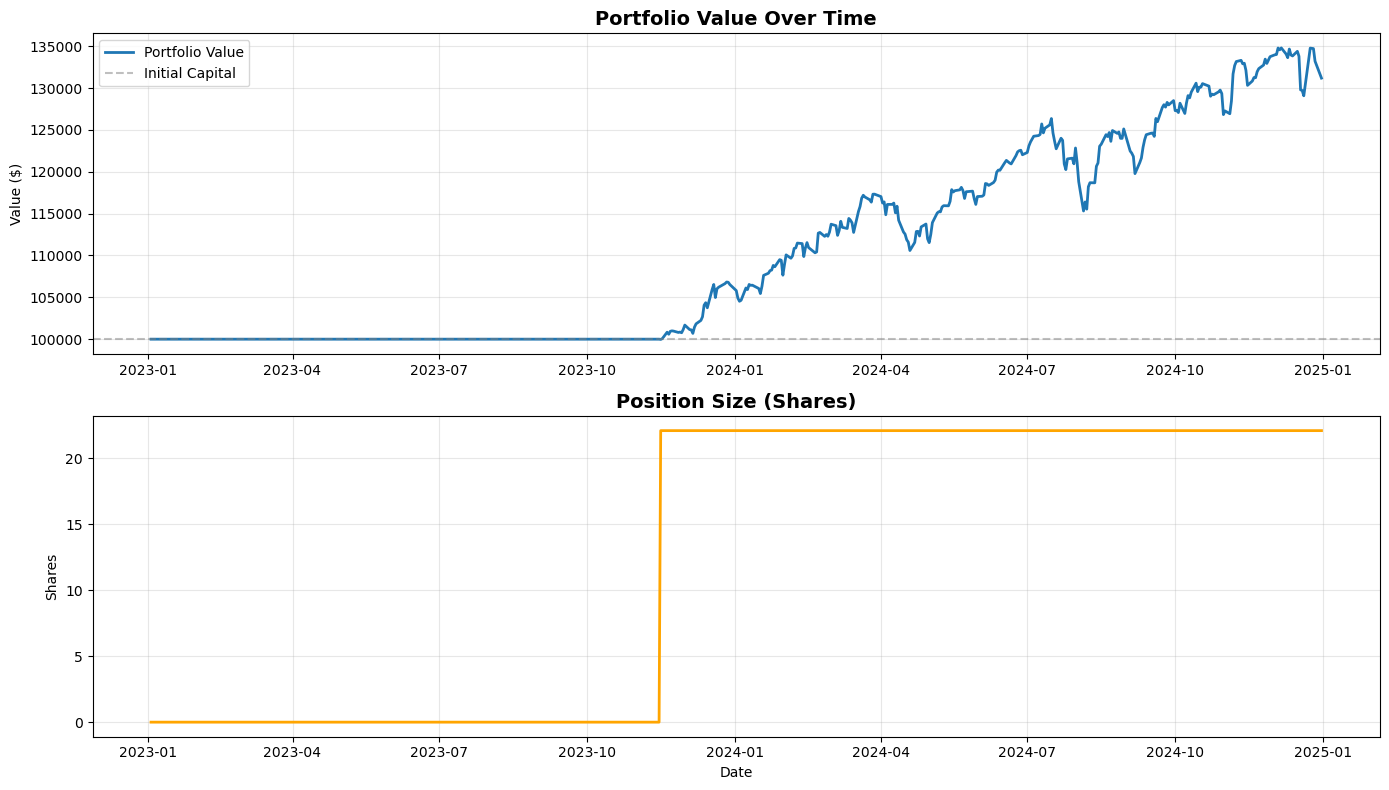

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Equity curve
ax1.plot(equity_df['Date'], equity_df['PortfolioValue'], linewidth=2, label='Portfolio Value')
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Position size over time
ax2.plot(equity_df['Date'], equity_df['Shares'], linewidth=2, color='orange')
ax2.set_title('Position Size (Shares)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Shares')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 🎓 Key Takeaways

### What You Learned:
1. **Position tracking** - Shares × Price = Position Value
2. **Cash management** - Subtract when buying, add when selling
3. **Portfolio value** - Always Cash + Position Value
4. **Transaction costs** - Applied to EVERY trade (both entry and exit)
5. **Signal-based trading** - Only trade when signal changes

### Critical Insights:
- ⚠️ **Transaction costs matter** - Even at 3bps, they add up!
- ⚠️ **Signal timing** - We only check signals once per day
- ⚠️ **Full investment** - This example uses 100% of capital (no risk management yet)
- ⚠️ **No short selling** - Signal=0 means flat, not short

### What's Missing (Coming Next):
- Multi-asset portfolios
- Position sizing (not always 100%)
- Risk limits (max position, max drawdown)
- Rebalancing logic
- Walk-forward validation

---

## ✅ Next Step

**Open: `02_portfolio_manager_deep_dive.ipynb`**

We'll see how `PortfolioManager` handles all of this automatically across multiple assets!